In [1]:
# Load dependencies - probably some here I don't need. How to check?
import pandas as pd
import numpy as np
import rasterio
import os
import matplotlib
from matplotlib import pyplot
from rasterio.plot import show
import pystac
import pystac_client
import planetary_computer
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import geopandas as gpd
from rich.table import Table
import rioxarray
import requests
from shapely.geometry import Polygon, shape, box
from shapely.ops import transform
from rich.table import Table
from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
from rasterstats import zonal_stats
from xrspatial.zonal import stats as zonal_stats
from geocube.api.core import make_geocube
import xarray
from azureml.core import Workspace, Dataset

In [223]:
# azureml-core of version 1.0.72 or higher is required

#subscription_id = '6c748216-f035-4623-80c3-29e1c28c7a56'
#resource_group = 'geo_microsoft_general'
#workspace_name = 'pop_heat_flood'

#workspace = Workspace(subscription_id, resource_group, workspace_name)

#dataset = Dataset.get_by_name(workspace, name='population_data')
#dataset.download(target_path='.', overwrite=True)

#dataset = Dataset.get_by_name(workspace, name='heat_data')
#dataset.download(target_path='.', overwrite=True)

NameError: name 'get_ambient_old' is not defined

In [ ]:
# for each population file in folder
# read in
# find bbox
# turn to points
# extract heat
# extract flood (using bbox)

In [3]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/az-testing/code/Users/p18q126'

In [28]:
# open heat data
heat_data = rasterio.open('global_mean_wbgt_30.tif', masked=True)                         

In [40]:
import os 

directory = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/az-testing/code/Users/p18q126/data'                # set directory

heat_data = rasterio.open('global_mean_wbgt_30.tif', masked=True)                                               # load heat data               

for fileName in os.listdir(directory):
    if fileName.endswith(".tif"):
        
        f = os.path.join(directory, fileName)
        
        countryCode = fileName[0:3]                                                                             # set country name

        outFileName = directory + '/' + countryCode + '_heat_flood_extract.csv'                                 # do not overwrite files already processes

        print(f"{countryCode} - Started") # STATUS CHECK

        country_pop = rioxarray.open_rasterio(f, masked=True)                                                   # open individual pop file with filepath

        country_box = country_pop.rio.bounds()                                                                  # find bounding box for country

        country_pop.name = "pop_data"                                                                           # change column header to pop_data

        country_pop_df = country_pop.squeeze().to_dataframe().reset_index()                                     # squeeze to data frame

        geometry = gpd.points_from_xy(country_pop_df.x, country_pop_df.y)                                       # set geometry

        country_pop_gdf = gpd.GeoDataFrame(country_pop_df, crs=country_pop.rio.crs, geometry=geometry)          # convert to geopandas df

        country_pop_gdf.dropna(subset=['pop_data'], how='all', inplace=True)                                    # remove pixels with no people

        country_pop_gdf.index = range(len(country_pop_gdf))
        coords = [(x,y) for x, y in zip(country_pop_gdf.x, country_pop_gdf.y)]
        country_pop_gdf['heat_value'] = [x[0] for x in heat_data.sample(coords)]                                # extract heat data

        print(f"{countryCode} - Heat Completed") # STATUS CHECK
        
        catalog = pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1", 
            modifier=planetary_computer.sign_inplace,)                                                          # access flood data on PC

        AOI = shape({ "coordinates": [[
            [country_box[0],
            country_box[1]],
            
            [country_box[0],
            country_box[3]],
            
            [country_box[2],
            country_box[1]],
            
            [country_box[2],
            country_box[3]]
            ]],
            "type": "Polygon"}).envelope                                                                        # use bounding box from before to get data for each country


        jrc = catalog.search(collections=["jrc-gsw"], intersects=AOI)
        items = jrc.item_collection()                                                                           # Use STACAPI to access the collection (find the number of images for each bounding box)

        n = len(items)
        doubles = dict()
        
        for i in range(0, n):
            item = items[i]
            
            doubles[i] = rioxarray.open_rasterio(item.assets["occurrence"].href, overview_level=4).squeeze()    # use this loop to load each image

        flood_data = merge_arrays(dataarrays = list(doubles.values()), crs = "EPSG:4326")                       # merge each image that's been loaded

        flood_data = flood_data.where(flood_data != 100)
        flood_data = flood_data.where(flood_data != 255)                                                        # Remove values of 100, and values of 255)
        
        flood_data.rio.write_nodata(flood_data.rio.nodata, encoded=True, inplace=True)                          # update nodata value to show the data has been masked

        country_pop_gdf_buff = country_pop_gdf.copy()
        country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)                               # create buffered polygon for each population point
        country_pop_gdf_buff["id"] = country_pop_gdf_buff.index + 1                                             # used to extract flood mean (also add index value here to merge back)

        out_grid = make_geocube(
            vector_data= country_pop_gdf_buff,
            measurements=["id"],
            like=flood_data, 
            )                                                                                                    # make geocube for zonal stats & ensure the data are on the same grid
            
        out_grid["flood_data"] = (flood_data.dims, flood_data.values, flood_data.attrs, flood_data.encoding)    # merge pop and flood together

        grouped_flood_data = out_grid.drop("spatial_ref").groupby(out_grid.id)
        grid_mean = grouped_flood_data.mean().rename({"flood_data": "flood_value"})                             # extract mean flood within the polygon

        print(f"{countryCode} - Flood Completed") # STATUS CHECK

        zonal_stats = xarray.merge([grid_mean]).to_dataframe()                                                  # convert resulting file to dataframe

        country_final_data = country_pop_gdf_buff.merge(zonal_stats, on='id')
        country_final_data = pd.DataFrame(country_final_data.drop(columns=['geometry', 'band', 'spatial_ref'])) # merge back in to data with heat

        country_final_data["country_iso"] = countryCode                                                         # add country code as a final column for reference
        
        country_final_data.to_csv(outFileName)

        print(f"{countryCode} - Completed & Saved") # STATUS CHECK

abw - Started
abw - Heat Completed
abw - Flood Completed
abw - Completed & Saved
afg - Started
afg - Heat Completed
afg - Flood Completed
afg - Completed & Saved
bgd - Started
bgd - Heat Completed
bgd - Flood Completed
bgd - Completed & Saved


/tmp/ipykernel_5440/2367068164.py:77: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)                               # create buffered polygon for each population point
/tmp/ipykernel_5440/2367068164.py:77: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)                               # create buffered polygon for each population point
Bad pipe message: %s [b'\x9cvN_\xd0\xe8\xe4\xfe[\x14\xa4\x81\x99_\n\xee\xf4\x0c \x9b\xc8\x0e\xe1\x8a\xd4(\xff\x8f\x85Y\\P?\xcfC[\xe2a\x8f\xa5\xae{l\xbe@\x1a\xf5:p\x9b\xe5\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e

In [36]:
outFileName

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/az-testing/code/Users/p18q126/dataabwheat_flood_extract.csv'

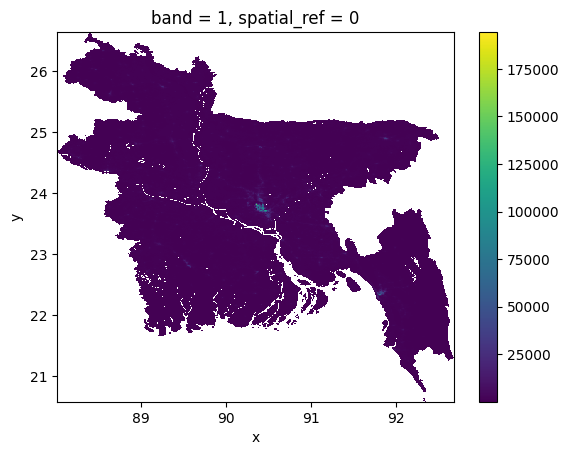

In [10]:
# Read pop data in
#countryCode = 'aus'
fileName = '_ppp_2020_1km_Aggregated_UNadj.tif'

filePath = directory + '/' + countryCode + fileName

country_pop = rioxarray.open_rasterio(filePath, masked=True)
country_pop.squeeze().plot.imshow()

In [11]:
# Find bbox
country_box = country_pop.rio.bounds()
print(country_box)

(88.01541632437963, 20.5745834483479, 92.67374963907962, 26.641250090747903)


In [248]:
# turn to points
country_pop.name = "pop_data"
country_pop_df = country_pop.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(country_pop_df.x, country_pop_df.y)
country_pop_gdf = gpd.GeoDataFrame(country_pop_df, crs=country_pop.rio.crs, geometry=geometry)

In [249]:
# remove pixels w/ no people
country_pop_gdf.dropna(subset=['pop_data'], how='all', inplace=True)

In [250]:
# extract heat
heat_data = rasterio.open('global_mean_wbgt_30.tif', masked=True)

country_pop_gdf.index = range(len(country_pop_gdf))
coords = [(x,y) for x, y in zip(country_pop_gdf.x, country_pop_gdf.y)]


country_pop_gdf['heat_value'] = [x[0] for x in heat_data.sample(coords)]
country_pop_gdf

,y,x,band,spatial_ref,pop_data,geometry,heat_value
0,-9.221250,142.169583,1,0,0.708876,POINT (142.16958 -9.22125),3.794118
1,-9.221250,142.236249,1,0,0.863518,POINT (142.23625 -9.22125),3.735294
2,-9.221250,142.244583,1,0,0.575959,POINT (142.24458 -9.22125),3.735294
3,-9.229583,142.161249,1,0,1.386173,POINT (142.16125 -9.22958),3.794118
4,-9.229583,142.169583,1,0,0.039001,POINT (142.16958 -9.22958),3.794118
...,...,...,...,...,...,...,...
10004115,-43.854583,146.977916,1,0,0.000002,POINT (146.97792 -43.85458),-9999.000000
10004116,-43.854583,146.994583,1,0,0.000005,POINT (146.99458 -43.85458),-9999.000000
10004117,-43.854583,147.002916,1,0,0.000016,POINT (147.00292 -43.85458),-9999.000000
10004118,-43.862916,146.969583,1,0,0.000005,POINT (146.96958 -43.86292),-9999.000000


In [252]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# create AOI using a bounding box for Bangladesh
AOI = shape({
  "coordinates": [
    [
      [country_box[0],
        country_box[1]],

      [country_box[0],
        country_box[3]],

      [country_box[2],
        country_box[1]],
        
      [country_box[2],
        country_box[3]]
    ]
  ],
  "type": "Polygon"
}).envelope

# execute a STAC API query using the bounding box for our selected area
jrc = catalog.search(collections=["jrc-gsw"], intersects=AOI)
items = jrc.item_collection()
print(f"Returned {len(items)} Items")

Returned 42 Items


In [253]:
n = len(items)
doubles = dict()

for i in range(0, n):
    item = items[i]
    
    doubles[i] = rioxarray.open_rasterio(item.assets["occurrence"].href, overview_level=4).squeeze()

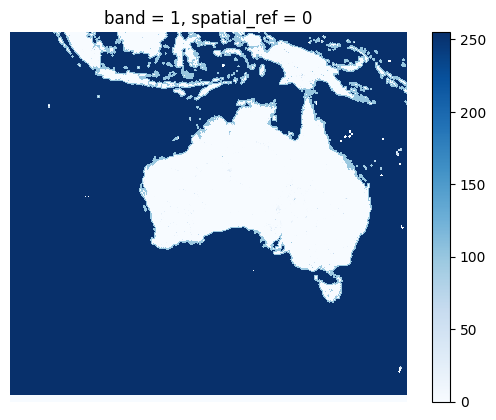

In [254]:
flood_data = merge_arrays(dataarrays = list(doubles.values()), crs = "EPSG:4326")
img = flood_data.plot(cmap="Blues", add_colorbar=True)
img.axes.set_axis_off();

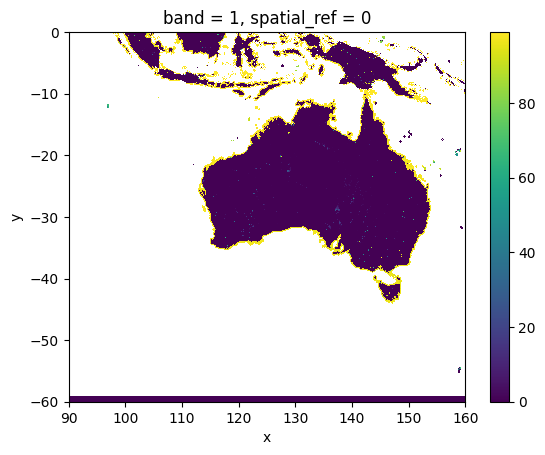

In [255]:
# Remove values of 100, and values of 255)
flood_data = flood_data.where(flood_data != 100)
flood_data = flood_data.where(flood_data != 255)

# update nodata value to show the data has been masked
flood_data.rio.write_nodata(flood_data.rio.nodata, encoded=True, inplace=True)

# Plot data with the values of 100 and 255 removed 
flood_data.squeeze().plot.imshow()

In [256]:
# Create a buffered polygon layer from your plot location points
country_pop_gdf_buff = country_pop_gdf.copy()

# Buffer each point using a 1km meter circle radius
# and replace the point geometry with the new buffered geometry
country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)
country_pop_gdf_buff["id"] = country_pop_gdf_buff.index + 1

/tmp/ipykernel_5213/713000173.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)


In [257]:
out_grid = make_geocube(
    vector_data= country_pop_gdf_buff,
    measurements=["id"],
    like=flood_data, # ensure the data are on the same grid
)

In [240]:
# merge the two together
out_grid["flood_data"] = (flood_data.dims, flood_data.values, flood_data.attrs, flood_data.encoding)

In [241]:
grouped_flood_data = out_grid.drop("spatial_ref").groupby(out_grid.id)

grid_mean = grouped_flood_data.mean().rename({"flood_data": "flood_value"})

In [242]:
zonal_stats = xarray.merge([grid_mean]).to_dataframe()

In [244]:
# merge back in w geopandas df from before
country_final_data = country_pop_gdf_buff.merge(zonal_stats, on='id')
country_final_data = pd.DataFrame(country_final_data.drop(columns=['geometry', 'band', 'spatial_ref']))

country_final_data["country_iso"] = countryCode
country_final_data

,y,x,pop_data,heat_value,id,flood_value,country_iso
0,26.637083,88.411250,465.867889,8.411765,1,0.0,bgd
1,26.628750,88.402916,591.919922,8.411765,2,0.0,bgd
2,26.628750,88.411250,1106.646851,8.411765,3,2.0,bgd
3,26.620417,88.394583,568.500732,6.676471,4,0.0,bgd
4,26.620417,88.402916,893.060913,8.411765,5,0.0,bgd
...,...,...,...,...,...,...,...
180808,20.595417,92.319583,17.995733,-9999.000000,180809,NaN,bgd
180809,20.595417,92.327916,254.004257,-9999.000000,180810,49.5,bgd
180810,20.587083,92.327916,30.814390,-9999.000000,180811,NaN,bgd
180811,20.587083,92.336250,63.411186,-9999.000000,180812,49.5,bgd


[]

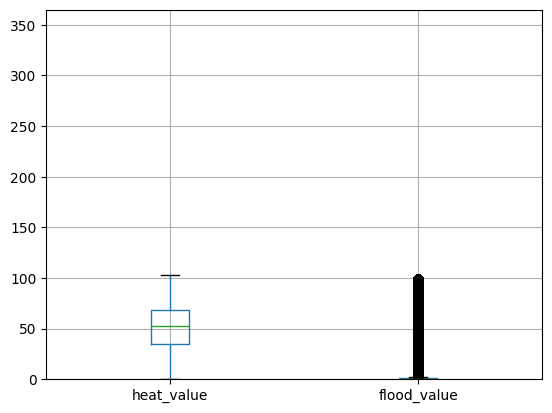

In [245]:
b_plot = country_final_data.boxplot(column = ['heat_value', 'flood_value']) 
b_plot.set_ylim(0,365)
b_plot.plot()